# REAL OPTION ANALYSIS
Without Excel add-on software to run Monte Calro simulation, can compute call option price of a project.

In [0]:
# Package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

%matplotlib inline

In [0]:
# Give the simulation size
np.random.seed(1)
N = 1000000

### Distribution function [ https://docs.scipy.org/doc/numpy/reference/routines.random.html ]

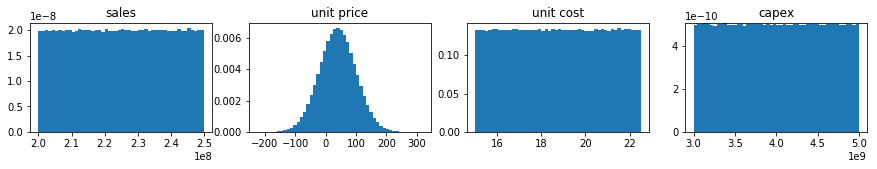

In [14]:
# Make Distributions of Variables
u_sales = np.random.uniform(200000000, 250000000, N).reshape(N, 1)
u_price = np.random.normal(40, 60, N).reshape(N, 1)
u_cost  = np.random.uniform(15, 22.5, N).reshape(N, 1)
capex   = np.random.uniform(3000000000, 5000000000, N).reshape(N, 1)

plt.figure(figsize=(15, 2))
nbins = 50
plt.subplot(141), plt.title("sales")
plt.hist(u_sales, nbins, density=True)
plt.subplot(142), plt.title("unit price")
plt.hist(u_price, nbins, density=True)
plt.subplot(143), plt.title("unit cost")
plt.hist(u_cost, nbins, density=True)
plt.subplot(144), plt.title("capex")
plt.hist(capex, nbins, density=True)
plt.savefig('Assumption.png')
plt.show()

In [0]:
# Compute Cash Flow Function

def compute_cashFlow(year_depreciation, u_sales, u_price, u_cost, capex) :

    sga_ratio = 0.2                       # SG&A = selling 5% + general & administration 15% = 20%
    dep = capex / year_depreciation       # Depreciation 7-year flat
    
    # Computing sales, operation profit, cash flow
    sales  = np.multiply( u_sales, u_price )
    p_cost = np.multiply( u_sales, u_cost )
    gls_margin = sales - p_cost
    op_profit  = gls_margin - ( sales * sga_ratio )

    nwc = ( p_cost - dep ) * ( 3/12 )      # Net working capital = cost * 3 months over 12 monthes
    c_tax = op_profit * 0.33               # Corporate tax rate = 33%
    fcf = op_profit - nwc - c_tax + dep

    return fcf

In [0]:
# Computing every year cash flow
u_sales_npv = u_sales
u_price_npv = u_price
u_cost_npv =  u_cost
capex_npv = capex
wacc = 0.04               # WACC
dcf_npv = np.zeros(N).reshape(N, 1)

for i in range(1, 5, 1) :
    fcf_npv = compute_cashFlow(7, u_sales_npv, u_price_npv, u_cost_npv, capex_npv)
    dcf_yearly = fcf_npv/(1+wacc)**(i)
    dcf_npv = np.c_[dcf_npv, dcf_yearly]
    
    u_price = u_price * 0.95     # assume 5% price reduction every year
    u_cost  = u_cost  * 0.95     # assume 5% cost reduction every year

In [0]:
# print(dcf_ey)
# print(dcf_ey.shape)

npv_0y mean = 1982.4174954777422
npv_0y std  = 26337.31547087625
correlations (sales, price, cost, capex) :  0.009594531386842483 0.9959726765735558 -0.061616958886081825 -0.006801763469732467


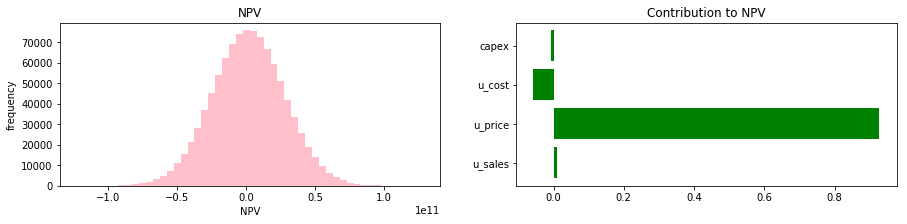

In [18]:
# NPV distribution and contribution by variables

dcf_0y = np.c_[dcf_npv, -capex_npv]
npv_0y = np.sum(dcf_0y, axis = 1, keepdims = True )
print('npv_0y mean =', np.mean(npv_0y)/1000000)
print('npv_0y std  =', np.std(npv_0y)/1000000)

corr_pv_sales =  np.corrcoef(npv_0y.reshape(1, N), u_sales_npv.reshape(1, N))[0, 1]
corr_pv_uprice = np.corrcoef(npv_0y.reshape(1, N), u_price_npv.reshape(1, N))[0, 1]
corr_pv_ucost =  np.corrcoef(npv_0y.reshape(1, N), u_cost_npv.reshape(1, N))[0, 1]
corr_pv_capex =  np.corrcoef(npv_0y.reshape(1, N), capex_npv.reshape(1, N))[0, 1]

print('correlations (sales, price, cost, capex) : ', corr_pv_sales, corr_pv_uprice, corr_pv_ucost, corr_pv_capex)
plt.figure(figsize=(15, 3))
plt.subplot(121)
plt.hist(npv_0y, nbins, color='pink')
plt.title("NPV")
plt.xlabel('NPV') 
plt.ylabel('frequency')

plt.subplot(122)
variables = np.array(['u_sales', 'u_price', 'u_cost', 'capex'])
correlation = np.array([corr_pv_sales, corr_pv_uprice, corr_pv_ucost, corr_pv_capex])
correlation_abs = np.abs(correlation)
correlation_ratio = correlation / np.sum(correlation_abs)
plt.barh(variables, correlation_ratio, color='green')
plt.title("Contribution to NPV")
plt.savefig('npv+sensitivity.png')

plt.show()

In [19]:
# Compute volatility
wacc        = 0.04          # WACC

# PV of cash-in at year 0
u_sales_p0  = u_sales
u_price_p0  = u_price
u_cost_p0   = u_cost
capex_p0    = capex

dcf_wocapex_y0 = np.zeros(N).reshape(N, 1)
for i in range(1, 5, 1) :
    fcf0 = compute_cashFlow(7, u_sales_p0, u_price_p0, u_cost_p0, capex_p0)
    dcf_yearly0 = fcf0/(1+wacc)**(i)
    dcf_wocapex_y0 = np.c_[dcf_wocapex_y0, dcf_yearly0]   
    u_price_p0 = u_price_p0 * 0.95     # assume 5% price reduction every year
    u_cost_p0  = u_cost_p0  * 0.95     # assume 5% cost reduction every year


# PV of cash-in at year 1
u_sales_p1  = u_sales
u_price_p1  = u_price
u_cost_p1   = u_cost
capex_p1    = capex

dcf_wocapex_y1 = np.zeros(N).reshape(N, 1)
for j in range(1, 5, 1) :
    fcf1 = compute_cashFlow(7, u_sales_p1, u_price_p1, u_cost_p1, capex_p1)
    dcf_yearly1 = fcf1/(1+wacc)**(j-1)
    dcf_wocapex_y1 = np.c_[dcf_wocapex_y1, dcf_yearly1]   
    u_price_p1 = u_price_p1 * 0.95     # assume 5% price reduction every year
    u_cost_p1  = u_cost_p1  * 0.95     # assume 5% cost reduction every year

pv_y0 = np.sum(dcf_wocapex_y0, axis=1, keepdims = True)
pv_y1 = np.sum(dcf_wocapex_y1, axis=1, keepdims = True)
print(pv_y1 - pv_y0, np.mean(pv_y1 - pv_y0)/1000000, (pv_y1 - pv_y0).shape)

[[ 1.62124668e+09]
 [-1.16659632e+08]
 [-3.35927962e+08]
 ...
 [ 1.84569045e+08]
 [ 6.45368464e+08]
 [ 9.27617062e+08]] 206.39112779733085 (1000000, 1)


0.05160397497440877 0.1995176107962529 (1000000, 1)


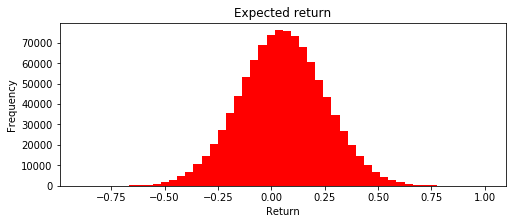

In [20]:
# Expected return at year 0
exp_return = (pv_y1-pv_y0) / np.median(capex)
print(np.mean(exp_return), np.std(exp_return), exp_return.shape)
plt.figure(figsize=(8, 3))
plt.hist(exp_return, nbins, color='red')
plt.title("Expected return")
plt.xlabel('Return') 
plt.ylabel('Frequency')
plt.savefig('Exp_return.png')
plt.show()

In [0]:
# Compute ROA using B/S model

def roa_BS(S, X, t, sigma, rf):
    d1 = (np.log(S/X)+(rf*t))/(sigma*np.sqrt(t))+0.5*sigma*np.sqrt(t)
    d2 = d1 - sigma*np.sqrt(t)
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    C = S*Nd1-X*(np.exp(-r*t))*Nd2
    
    return d1, d2, Nd1, Nd2, C

In [0]:
sig_median = np.std(exp_return)
ti = ([1, 2, 3, 4, 5])
sig = ([0.8*sig_median, 0.9*sig_median, sig_median, 1.1*sig_median, 1.2*sig_median])
r = 0.0001

ROA = np.zeros(25).reshape(5, 5)

for i in range(0, 5) :
    for j in range(0, 5) :
        d1, d2, Nd1, Nd2, C = roa_BS(np.mean(npv_0y), np.median(capex), ti[i], sig[j], r) ;
        ROA[i, j] = round(C,2)/1000000 ;

In [23]:
print(np.mean(npv_0y))
print(np.median(capex))

1982417495.4777422
3999519957.5165195


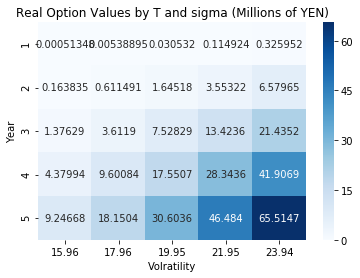

In [24]:
df_roa = pd.DataFrame(data=ROA,
                      index=['1', '2', '3', '4', '5'],
                      columns=(round(0.8*sig_median*100, 2), round(0.9*sig_median*100, 2),
                               round(sig_median*100, 2), round(1.1*sig_median*100, 2), round(1.2*sig_median*100, 2)))

sns.heatmap(df_roa, annot=True, fmt='g', cmap='Blues')
plt.title('Real Option Values by T and sigma (Millions of YEN)')
plt.xlabel('Volratility') 
plt.ylabel('Year')
plt.savefig('ROA_heatmap.png')
plt.show()